# MIVA - Fase 2: Experimento Empírico

**Metodologia de Identificação de Viés Amplificado**

Este notebook implementa a metodologia MIVA para detectar amplificação de viés em modelos de classificação treinados com anotações de diferentes grupos.

## 1. Setup e Configurações

In [28]:
# Importações
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
from datetime import datetime

# Scikit-learn
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    cohen_kappa_score,
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix
)
from sklearn.base import clone

# Análise estatística
from scipy.stats import chi2_contingency

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações
warnings.filterwarnings('ignore')

# ============================================================================
# ESTILO ACADÊMICO NATURE (azulado)
# ============================================================================
plt.style.use('seaborn-v0_8-whitegrid')

# Paleta Nature: tons de azul acadêmico
NATURE_BLUE = '#0C4A6E'       # Azul principal escuro
NATURE_BLUE_MED = '#0284C7'   # Azul médio
NATURE_BLUE_LIGHT = '#38BDF8' # Azul claro
NATURE_GRAY = '#64748B'       # Cinza complementar
NATURE_ACCENT = '#1E3A5F'     # Azul accent

# Paleta para gráficos categóricos
NATURE_PALETTE = [NATURE_BLUE, NATURE_BLUE_MED, NATURE_BLUE_LIGHT, NATURE_GRAY]

# Paleta para modelos (Nature style)
CORES_MODELOS_NATURE = {
    'SVM': '#0C4A6E',  # Azul escuro
    'NB': '#0284C7',   # Azul médio  
    'RF': '#0EA5E9',   # Azul claro
    'LR': '#38BDF8'    # Azul mais claro
}

# Cores de intensidade (mantidas para gráficos semânticos)
COR_NEGATIVA = '#DC2626'  # Vermelho
COR_NEUTRA = '#6B7280'    # Cinza
COR_POSITIVA = '#0284C7'  # Azul

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'axes.labelweight': 'bold',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--'
})

sns.set_palette(NATURE_PALETTE)
pd.options.display.float_format = '{:.4f}'.format

print("✓ Bibliotecas importadas com sucesso!")
print("✓ Estilo acadêmico Nature aplicado")

✓ Bibliotecas importadas com sucesso!
✓ Estilo acadêmico Nature aplicado


In [29]:
# Configurações globais
if 'Path' not in globals():
	from pathlib import Path

SEED = 42
N_FOLDS = 5
INPUT_FILE = "data/logs_processados/MQD-1209_majoritarias.csv"

# Diretórios
DATA_DIR = Path("data")
RESULTS_DIR = DATA_DIR / "resultados_empiricos"
GRAFICOS_DIR = RESULTS_DIR / "graficos_empiricos"

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
GRAFICOS_DIR.mkdir(parents=True, exist_ok=True)

np.random.seed(SEED)

# Mapeamento de classes
CLASSE_MAP = {'negativa': -1, 'neutra': 0, 'positiva': 1}
CLASSE_REVERSO = {v: k for k, v in CLASSE_MAP.items()}

print("="*80)
print("CONFIGURAÇÕES")
print("="*80)
print(f"Seed: {SEED}")
print(f"K-Fold CV: {N_FOLDS} folds")
print(f"Arquivo: {INPUT_FILE}")
print("="*80)

CONFIGURAÇÕES
Seed: 42
K-Fold CV: 5 folds
Arquivo: data/logs_processados/MQD-1209_majoritarias.csv


In [30]:
# Modelos de classificação (hiperparâmetros padrão)
modelos = {
    'SVM': SVC(kernel='linear', C=1.0, random_state=SEED),
    'NB': MultinomialNB(alpha=1.0),
    'RF': RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1),
    'LR': LogisticRegression(max_iter=1000, C=1.0, random_state=SEED, n_jobs=-1)
}

print("="*80)
print("MODELOS CONFIGURADOS")
print("="*80)
for nome, modelo in modelos.items():
    params = modelo.get_params()
    params_rel = {k: v for k, v in params.items() 
                  if k in ['C', 'alpha', 'kernel', 'n_estimators', 'solver', 'random_state']}
    print(f"\n{nome}:")
    for param, valor in params_rel.items():
        print(f"    {param}: {valor}")

MODELOS CONFIGURADOS

SVM:
    C: 1.0
    kernel: linear
    random_state: 42

NB:
    alpha: 1.0

RF:
    n_estimators: 100
    random_state: 42

LR:
    C: 1.0
    random_state: 42
    solver: lbfgs


## MÓDULO I: Análise de Consistência Preliminar (Baseline)

Estabelece a linha de base da concordância entre os dois grupos de anotadores.

In [31]:
# Carregar dados
print("="*80)
print("MÓDULO I: BASELINE")
print("="*80)

df = pd.read_csv(INPUT_FILE, sep='\t')
print(f"\n✓ {len(df)} frases carregadas")
print(f"✓ Colunas: {list(df.columns)}")

df.head()

MÓDULO I: BASELINE

✓ 1209 frases carregadas
✓ Colunas: ['frase', 'duracao_media_masculino', 'total_classificacoes_masculino', 'classificacao_majoritaria_masculino', 'votos_maioria_masculino', 'total_positiva_masculino', 'total_negativa_masculino', 'total_neutra_masculino', 'duracao_media_feminino', 'total_classificacoes_feminino', 'classificacao_majoritaria_feminino', 'votos_maioria_feminino', 'total_positiva_feminino', 'total_negativa_feminino', 'total_neutra_feminino', 'concordancia_grupos']


,frase,duracao_media_masculino,total_classificacoes_masculino,classificacao_majoritaria_masculino,votos_maioria_masculino,total_positiva_masculino,total_negativa_masculino,total_neutra_masculino,duracao_media_feminino,total_classificacoes_feminino,classificacao_majoritaria_feminino,votos_maioria_feminino,total_positiva_feminino,total_negativa_feminino,total_neutra_feminino,concordancia_grupos
0,Comprei meu livro.,24.8965,4,negativa,4,0,4,0,29.0708,4,negativa,4,0,4,0,1
1,Confesso que aquilo me dava um prazer quase qu...,4.6967,4,negativa,3,0,3,1,6.6075,4,negativa,4,0,4,0,1
2,"Mais uma vez eu to aqui me lamentando, eu esto...",2.3243,4,neutra,3,1,0,3,10.0270,4,neutra,3,1,0,3,1
3,"Ela me fala coisas e depois diz que não falou,...",6.4900,4,positiva,4,4,0,0,8.5228,4,positiva,4,4,0,0,1
4,Eles brigaram e ela terminou com ele.,5.9215,4,negativa,4,0,4,0,9.7170,4,negativa,4,0,4,0,1


In [32]:
# Mapear classes para valores numéricos
y_masculino = df['classificacao_majoritaria_masculino'].map(CLASSE_MAP)
y_feminino = df['classificacao_majoritaria_feminino'].map(CLASSE_MAP)

print("\nMapeamento:")
for classe, valor in CLASSE_MAP.items():
    print(f"  {classe:>10} → {valor:>2}")


Mapeamento:
    negativa → -1
      neutra →  0
    positiva →  1


In [33]:
# Calcular métricas de concordância inicial
kappa_inicial = cohen_kappa_score(y_masculino, y_feminino)
kappa_weighted = cohen_kappa_score(y_masculino, y_feminino, weights='linear')
concordancia = np.mean(y_masculino == y_feminino)

contingency = pd.crosstab(y_masculino, y_feminino)
chi2, p_value, dof, expected = chi2_contingency(contingency)

n = len(y_masculino)
cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))

print(f"\nMétricas de Baseline:")
print(f"  κ_inicial (Cohen)    : {kappa_inicial:.4f}")
print(f"  κ_inicial (Weighted) : {kappa_weighted:.4f}")
print(f"  Concordância         : {concordancia:.4f} ({100*concordancia:.2f}%)")
print(f"  χ²                   : {chi2:.2f} (p < {p_value:.2e})")
print(f"  Cramér's V           : {cramers_v:.4f}")

df_baseline = pd.DataFrame({
    'metrica': ['Cohen_Kappa', 'Weighted_Kappa', 'Concordancia', 
                'Chi2', 'p_value', 'Cramers_V', 'N_amostras'],
    'valor': [kappa_inicial, kappa_weighted, concordancia, 
              chi2, p_value, cramers_v, n]
})

df_baseline


Métricas de Baseline:
  κ_inicial (Cohen)    : 0.7652
  κ_inicial (Weighted) : 0.8121
  Concordância         : 0.8445 (84.45%)
  χ²                   : 1422.18 (p < 1.07e-306)
  Cramér's V           : 0.7669


,metrica,valor
0,Cohen_Kappa,0.7652
1,Weighted_Kappa,0.8121
2,Concordancia,0.8445
3,Chi2,1422.1822
4,p_value,0.0000
5,Cramers_V,0.7669
6,N_amostras,1209.0000


In [34]:
# Bootstrap para IC do κ_inicial
print("\nCalculando intervalo de confiança (bootstrap)...")

n_bootstrap = 1000
kappas_bootstrap = []

for _ in range(n_bootstrap):
    idx = np.random.choice(len(y_masculino), size=len(y_masculino), replace=True)
    kappa_sample = cohen_kappa_score(y_masculino.iloc[idx], y_feminino.iloc[idx])
    kappas_bootstrap.append(kappa_sample)

ic_lower = np.percentile(kappas_bootstrap, 2.5)
ic_upper = np.percentile(kappas_bootstrap, 97.5)

print(f"  IC 95%: [{ic_lower:.4f}, {ic_upper:.4f}]")

# Adicionar ao baseline
df_baseline_ic = pd.DataFrame({
    'metrica': ['Kappa_IC95_Lower', 'Kappa_IC95_Upper'],
    'valor': [ic_lower, ic_upper]
})
df_baseline = pd.concat([df_baseline, df_baseline_ic], ignore_index=True)


Calculando intervalo de confiança (bootstrap)...
  IC 95%: [0.7352, 0.7962]


In [35]:
# Salvar baseline
output_file = RESULTS_DIR / "metricas_consistencia_baseline.csv"
df_baseline.to_csv(output_file, index=False)
print(f"\n✓ Baseline salvo: {output_file}")


✓ Baseline salvo: data\resultados_empiricos\metricas_consistencia_baseline.csv


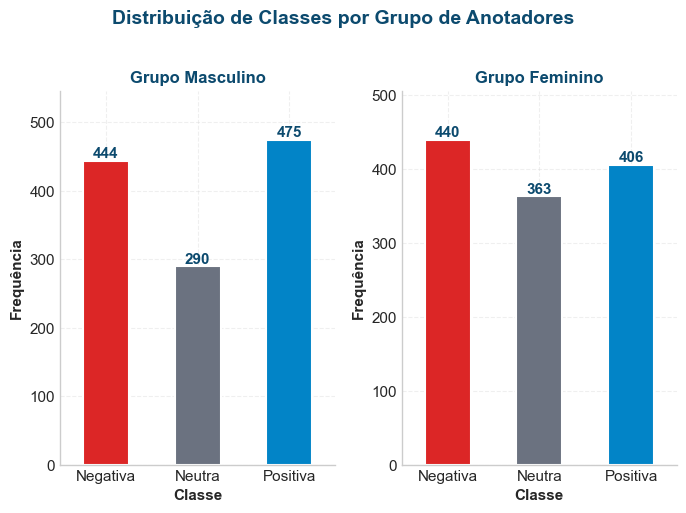

In [36]:
# Visualização: Distribuição de classes (Estilo Nature)
fig, axes = plt.subplots(1, 2, figsize=(7, 5))

# Cores semânticas para classes de sentimento
cores_classes = [COR_NEGATIVA, COR_NEUTRA, COR_POSITIVA]

for idx, grupo in enumerate(['masculino', 'feminino']):
    col = f'classificacao_majoritaria_{grupo}'
    dist = df[col].value_counts().sort_index()
    
    ax = axes[idx]
    bars = dist.plot(kind='bar', ax=ax, color=cores_classes, edgecolor='white', linewidth=1.5)
    ax.set_title(f'Grupo {grupo.capitalize()}', fontsize=12, fontweight='bold', color=NATURE_BLUE)
    ax.set_xlabel('Classe', fontsize=11)
    ax.set_ylabel('Frequência', fontsize=11)
    ax.set_xticklabels(['Negativa', 'Neutra', 'Positiva'], rotation=0)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    for container in ax.containers:
        ax.bar_label(container, fontsize=11, fontweight='bold', color=NATURE_BLUE)
    
    ax.set_ylim(0, dist.max() * 1.15)

plt.suptitle('Distribuição de Classes por Grupo de Anotadores', fontsize=14, fontweight='bold', color=NATURE_BLUE, y=1.02)
plt.tight_layout()
plt.savefig(GRAFICOS_DIR / 'distribuicao_classes.png', dpi=300, bbox_inches='tight')
plt.show()

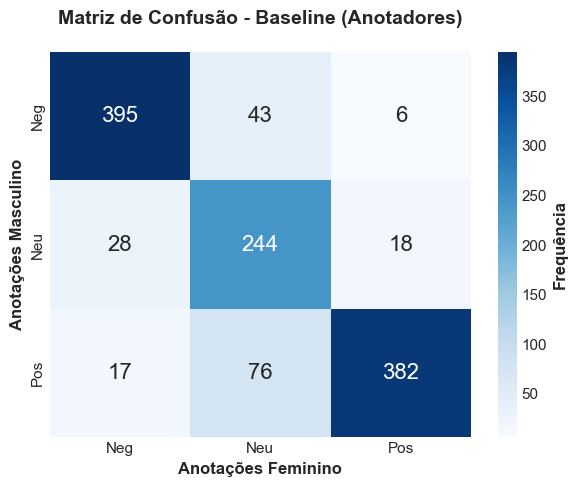

In [37]:
# Matriz de confusão - Baseline
cm = confusion_matrix(y_masculino, y_feminino, labels=[-1, 0, 1])

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Neg', 'Neu', 'Pos'],
            yticklabels=['Neg', 'Neu', 'Pos'],
            ax=ax, cbar_kws={'label': 'Frequência'},
            annot_kws={'fontsize': 16})

ax.set_title('Matriz de Confusão - Baseline (Anotadores)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Anotações Feminino', fontsize=12)
ax.set_ylabel('Anotações Masculino', fontsize=12)

plt.tight_layout()
plt.savefig(GRAFICOS_DIR / 'matriz_confusao_baseline.png', dpi=300, bbox_inches='tight')
plt.show()

## MÓDULO II: Treinamento Pareado dos Modelos

Treina modelos separadamente em cada grupo e avalia a concordância entre suas predições.

In [38]:
# Preparar features TF-IDF
print("="*80)
print("MÓDULO II: TREINAMENTO PAREADO")
print("="*80)

stopwords_pt = [
    'a', 'o', 'e', 'é', 'de', 'da', 'do', 'em', 'um', 'uma', 'os', 'as', 'dos', 'das',
    'ao', 'à', 'às', 'no', 'na', 'nos', 'nas', 'por', 'para', 'com', 'sem', 'sob', 'sobre',
    'que', 'se', 'me', 'te', 'lhe', 'como', 'mas', 'ou', 'quando', 'onde', 'qual', 'quais',
    'ele', 'ela', 'eles', 'elas', 'eu', 'tu', 'nós', 'vós', 'você', 'vocês',
    'meu', 'minha', 'meus', 'minhas', 'seu', 'sua', 'seus', 'suas', 'nosso', 'nossa',
    'este', 'esta', 'esse', 'essa', 'aquele', 'aquela', 'isto', 'isso', 'aquilo',
    'foi', 'ser', 'ter', 'estar', 'fazer', 'ir', 'ver', 'dar', 'saber',
    'há', 'muito', 'mais', 'menos', 'bem', 'mal', 'já', 'ainda', 'só', 'também',
    'até', 'depois', 'antes', 'agora', 'então', 'aqui', 'ali', 'lá',
    'sim', 'não', 'nem', 'nunca', 'sempre', 'nada', 'tudo', 'todo', 'algum', 'nenhum'
]

vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 3),
    min_df=3,
    max_df=0.90,
    strip_accents=None,
    stop_words=stopwords_pt,
    sublinear_tf=True,
    use_idf=True,
    norm='l2'
)

X = vectorizer.fit_transform(df['frase'])

print(f"\n✓ Matriz TF-IDF: {X.shape}")
print(f"✓ Vocabulário: {len(vectorizer.vocabulary_)} termos")

MÓDULO II: TREINAMENTO PAREADO

✓ Matriz TF-IDF: (1209, 978)
✓ Vocabulário: 978 termos


In [39]:
# Configurar validação cruzada
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

resultados_modelos = []
predicoes_totais = []

print(f"\n✓ StratifiedKFold: {N_FOLDS} folds")


✓ StratifiedKFold: 5 folds


In [40]:
# Treinamento pareado com validação cruzada
print("\nIniciando treinamento pareado...\n")

inicio_treino = datetime.now()

for nome_modelo, modelo_template in modelos.items():
    print(f"  >>> {nome_modelo}")
    print(f"      " + "-"*40)
    
    metricas_folds = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_masculino), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_masc_train, y_masc_test = y_masculino.iloc[train_idx], y_masculino.iloc[test_idx]
        y_fem_train, y_fem_test = y_feminino.iloc[train_idx], y_feminino.iloc[test_idx]
        
        # Treinar modelo masculino
        modelo_masc = clone(modelo_template)
        modelo_masc.fit(X_train, y_masc_train)
        pred_masc = modelo_masc.predict(X_test)
        
        # Treinar modelo feminino
        modelo_fem = clone(modelo_template)
        modelo_fem.fit(X_train, y_fem_train)
        pred_fem = modelo_fem.predict(X_test)
        
        # Métricas
        kappa_inter = cohen_kappa_score(pred_masc, pred_fem)
        kappa_weighted_inter = cohen_kappa_score(pred_masc, pred_fem, weights='linear')
        concordancia_inter = np.mean(pred_masc == pred_fem)
        
        acc_masc = accuracy_score(y_masc_test, pred_masc)
        acc_fem = accuracy_score(y_fem_test, pred_fem)
        
        prec_masc, rec_masc, f1_masc, _ = precision_recall_fscore_support(
            y_masc_test, pred_masc, average='weighted', zero_division=0
        )
        prec_fem, rec_fem, f1_fem, _ = precision_recall_fscore_support(
            y_fem_test, pred_fem, average='weighted', zero_division=0
        )
        
        metricas_folds.append({
            'modelo': nome_modelo,
            'fold': fold,
            'kappa_inter_modelos': kappa_inter,
            'kappa_weighted_inter_modelos': kappa_weighted_inter,
            'concordancia_inter_modelos': concordancia_inter,
            'acc_masculino': acc_masc,
            'acc_feminino': acc_fem,
            'precision_masculino': prec_masc,
            'precision_feminino': prec_fem,
            'recall_masculino': rec_masc,
            'recall_feminino': rec_fem,
            'f1_masculino': f1_masc,
            'f1_feminino': f1_fem
        })
        
        # Armazenar predições
        for i, idx in enumerate(test_idx):
            predicoes_totais.append({
                'modelo': nome_modelo,
                'fold': fold,
                'frase_id': int(idx),
                'frase': df.iloc[idx]['frase'][:100],
                'real_masculino': int(y_masc_test.iloc[i]),
                'real_feminino': int(y_fem_test.iloc[i]),
                'pred_masculino': int(pred_masc[i]),
                'pred_feminino': int(pred_fem[i]),
                'concordancia_real': int(y_masc_test.iloc[i] == y_fem_test.iloc[i]),
                'concordancia_pred': int(pred_masc[i] == pred_fem[i])
            })
        
        print(f"      Fold {fold}: κ={kappa_inter:.4f}, Acc_M={acc_masc:.4f}, Acc_F={acc_fem:.4f}")
    
    # Agregar
    df_folds = pd.DataFrame(metricas_folds)
    
    metricas_agregadas = {
        'modelo': nome_modelo,
        'kappa_mean': df_folds['kappa_inter_modelos'].mean(),
        'kappa_std': df_folds['kappa_inter_modelos'].std(),
        'kappa_weighted_mean': df_folds['kappa_weighted_inter_modelos'].mean(),
        'kappa_weighted_std': df_folds['kappa_weighted_inter_modelos'].std(),
        'concordancia_mean': df_folds['concordancia_inter_modelos'].mean(),
        'concordancia_std': df_folds['concordancia_inter_modelos'].std(),
        'acc_masculino_mean': df_folds['acc_masculino'].mean(),
        'acc_masculino_std': df_folds['acc_masculino'].std(),
        'acc_feminino_mean': df_folds['acc_feminino'].mean(),
        'acc_feminino_std': df_folds['acc_feminino'].std(),
        'f1_masculino_mean': df_folds['f1_masculino'].mean(),
        'f1_feminino_mean': df_folds['f1_feminino'].mean()
    }
    
    resultados_modelos.append(metricas_agregadas)
    
    print(f"      ✓ κ_médio = {metricas_agregadas['kappa_mean']:.4f} ±{metricas_agregadas['kappa_std']:.4f}\n")

duracao = datetime.now() - inicio_treino
print(f"✓ Treinamento concluído em {duracao}")


Iniciando treinamento pareado...

  >>> SVM
      ----------------------------------------
      Fold 1: κ=0.5015, Acc_M=0.3678, Acc_F=0.3388
      Fold 2: κ=0.4774, Acc_M=0.3388, Acc_F=0.3388
      Fold 3: κ=0.4267, Acc_M=0.3554, Acc_F=0.3347
      Fold 4: κ=0.4579, Acc_M=0.2851, Acc_F=0.3017
      Fold 5: κ=0.4601, Acc_M=0.3402, Acc_F=0.3278
      ✓ κ_médio = 0.4647 ±0.0275

  >>> NB
      ----------------------------------------
      Fold 1: κ=0.5054, Acc_M=0.3678, Acc_F=0.3471
      Fold 2: κ=0.5059, Acc_M=0.3884, Acc_F=0.3595
      Fold 3: κ=0.4721, Acc_M=0.3802, Acc_F=0.3430
      Fold 4: κ=0.5019, Acc_M=0.2810, Acc_F=0.3347
      Fold 5: κ=0.4456, Acc_M=0.3610, Acc_F=0.3071
      ✓ κ_médio = 0.4862 ±0.0267

  >>> RF
      ----------------------------------------
      Fold 1: κ=0.4877, Acc_M=0.3802, Acc_F=0.3182
      Fold 2: κ=0.4140, Acc_M=0.3678, Acc_F=0.3512
      Fold 3: κ=0.4057, Acc_M=0.4050, Acc_F=0.3140
      Fold 4: κ=0.4564, Acc_M=0.3512, Acc_F=0.3182
      Fold 5: 

In [41]:
# Criar DataFrames de resultados
df_metricas_modelos = pd.DataFrame(resultados_modelos)
df_predicoes = pd.DataFrame(predicoes_totais)

print(f"\n✓ Métricas: {df_metricas_modelos.shape}")
print(f"✓ Predições: {df_predicoes.shape}")

df_metricas_modelos


✓ Métricas: (4, 13)
✓ Predições: (4836, 10)


,modelo,kappa_mean,kappa_std,kappa_weighted_mean,kappa_weighted_std,concordancia_mean,concordancia_std,acc_masculino_mean,acc_masculino_std,acc_feminino_mean,acc_feminino_std,f1_masculino_mean,f1_feminino_mean
0,SVM,0.4647,0.0275,0.5149,0.0265,0.6642,0.0215,0.3375,0.0316,0.3284,0.0156,0.3155,0.3229
1,NB,0.4862,0.0267,0.5389,0.0233,0.6824,0.0217,0.3557,0.0431,0.3383,0.0196,0.3204,0.3285
2,RF,0.4378,0.0339,0.4860,0.0401,0.6650,0.0417,0.3705,0.0231,0.3317,0.0206,0.3356,0.3218
3,LR,0.4986,0.0433,0.5496,0.0323,0.6832,0.0307,0.3408,0.0248,0.3300,0.0201,0.3176,0.3254


In [42]:
# Salvar resultados
df_metricas_modelos.to_csv(RESULTS_DIR / "metricas_modelos_pareados.csv", index=False)
df_predicoes.to_csv(RESULTS_DIR / "predicoes_completas.csv", index=False)

print("\n✓ Arquivos salvos:")
print("  • metricas_modelos_pareados.csv")
print("  • predicoes_completas.csv")


✓ Arquivos salvos:
  • metricas_modelos_pareados.csv
  • predicoes_completas.csv


## MÓDULO III: Avaliação de Divergência entre Modelos

Análise estatística das predições pareadas.

In [43]:
# Análise estatística das predições
print("="*80)
print("MÓDULO III: DIVERGÊNCIA")
print("="*80)

analises = []

for modelo in modelos.keys():
    pred_modelo = df_predicoes[df_predicoes['modelo'] == modelo]
    
    contingency = pd.crosstab(pred_modelo['pred_masculino'], pred_modelo['pred_feminino'])
    chi2, p_value, dof, expected = chi2_contingency(contingency)
    
    n = len(pred_modelo)
    min_dim = min(contingency.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0.0
    
    kappa_mean = df_metricas_modelos[df_metricas_modelos['modelo'] == modelo]['kappa_mean'].values[0]
    
    analises.append({
        'modelo': modelo,
        'kappa_modelos': kappa_mean,
        'chi2': chi2,
        'p_value': p_value,
        'cramers_v': cramers_v,
        'n_predicoes': n
    })
    
    print(f"\n  {modelo}:")
    print(f"    κ_modelos = {kappa_mean:.4f}")
    print(f"    χ² = {chi2:.2f} (p < {p_value:.2e})")
    print(f"    Cramér's V = {cramers_v:.4f}")

df_analises = pd.DataFrame(analises)
df_analises

MÓDULO III: DIVERGÊNCIA

  SVM:
    κ_modelos = 0.4647
    χ² = 514.69 (p < 4.45e-110)
    Cramér's V = 0.4614

  NB:
    κ_modelos = 0.4862
    χ² = 588.06 (p < 5.93e-126)
    Cramér's V = 0.4932

  RF:
    κ_modelos = 0.4378
    χ² = 473.82 (p < 3.08e-101)
    Cramér's V = 0.4427

  LR:
    κ_modelos = 0.4986
    χ² = 609.40 (p < 1.43e-130)
    Cramér's V = 0.5020


,modelo,kappa_modelos,chi2,p_value,cramers_v,n_predicoes
0,SVM,0.4647,514.6908,0.0000,0.4614,1209
1,NB,0.4862,588.0640,0.0000,0.4932,1209
2,RF,0.4378,473.8158,0.0000,0.4427,1209
3,LR,0.4986,609.3983,0.0000,0.5020,1209


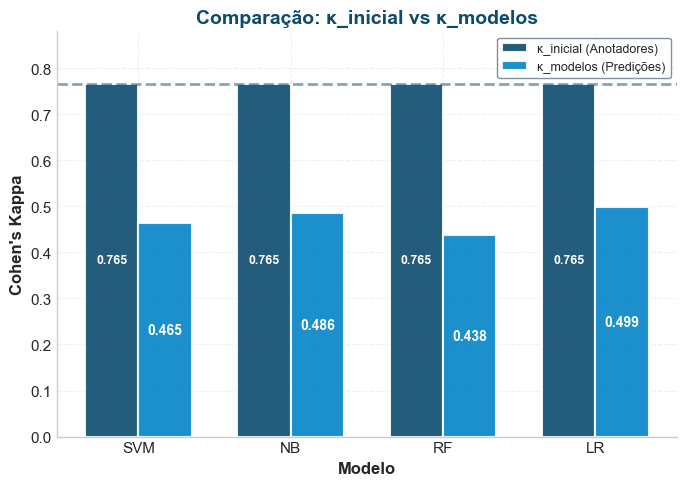

In [44]:
# Visualizar κ_inicial vs κ_modelos (Estilo Nature)
fig, ax = plt.subplots(figsize=(7, 5))

x = np.arange(len(df_analises))
width = 0.35

bars1 = ax.bar(x - width/2, [kappa_inicial] * len(df_analises), width, 
               label='κ_inicial (Anotadores)', color=NATURE_BLUE, alpha=0.9,
               edgecolor='white', linewidth=1.5)
bars2 = ax.bar(x + width/2, df_analises['kappa_modelos'], width,
               label='κ_modelos (Predições)', color=NATURE_BLUE_MED, alpha=0.9,
               edgecolor='white', linewidth=1.5)

for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height * 0.5,
            f'{height:.3f}', ha='center', va='center', fontsize=9, 
            fontweight='bold', color='white')

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height * 0.5,
            f'{height:.3f}', ha='center', va='center', fontsize=10, 
            fontweight='bold', color='white')

ax.axhline(y=kappa_inicial, color=NATURE_BLUE, linestyle='--', alpha=0.5, linewidth=2)
ax.set_xlabel('Modelo', fontsize=12, fontweight='bold')
ax.set_ylabel("Cohen's Kappa", fontsize=12, fontweight='bold')
ax.set_title('Comparação: κ_inicial vs κ_modelos', fontsize=14, fontweight='bold', color=NATURE_BLUE)
ax.set_xticks(x)
ax.set_xticklabels(df_analises['modelo'])
ax.legend(frameon=True, facecolor='white', edgecolor=NATURE_GRAY, fontsize=9)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, max(kappa_inicial, df_analises['kappa_modelos'].max()) * 1.15)

plt.tight_layout()
plt.savefig(GRAFICOS_DIR / 'comparacao_kappas.png', dpi=300, bbox_inches='tight')
plt.show()

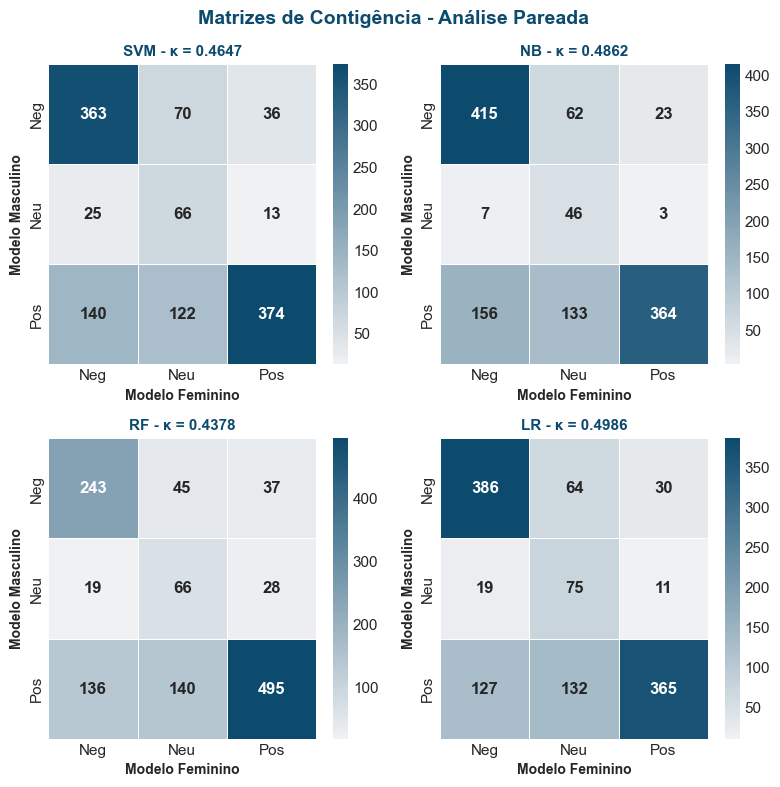

In [45]:
# Matrizes de confusão dos modelos
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

# Cmap azul acadêmico
cmap_nature = sns.light_palette(NATURE_BLUE, as_cmap=True)

for idx, modelo in enumerate(modelos.keys()):
    pred_modelo = df_predicoes[df_predicoes['modelo'] == modelo]
    
    cm = confusion_matrix(pred_modelo['pred_masculino'], pred_modelo['pred_feminino'],
                         labels=[-1, 0, 1])
    
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap_nature,
                xticklabels=['Neg', 'Neu', 'Pos'], 
                yticklabels=['Neg', 'Neu', 'Pos'],
                ax=ax, #cbar_kws={'label': 'Frequência'},
                annot_kws={'fontsize': 12, 'fontweight': 'bold'},
                linewidths=0.5, linecolor='white')
    
    kappa = df_metricas_modelos[df_metricas_modelos['modelo'] == modelo]['kappa_mean'].values[0]
    
    ax.set_title(f'{modelo} - κ = {kappa:.4f}', fontsize=11, fontweight='bold', color=NATURE_BLUE)
    ax.set_xlabel('Modelo Feminino', fontsize=10)
    ax.set_ylabel('Modelo Masculino', fontsize=10)

plt.suptitle('Matrizes de Contigência - Análise Pareada', fontsize=14, fontweight='bold', color=NATURE_BLUE)
plt.tight_layout()
plt.savefig(GRAFICOS_DIR / 'matrizes_confusao_modelos.png', dpi=300, bbox_inches='tight')
plt.show()

## MÓDULO IV: Comparação e Detecção de Amplificação

**Núcleo da MIVA**: Calcula Δκ para detectar amplificação de viés.

In [46]:
# Calcular Δκ (Delta Kappa)
print("="*80)
print("MÓDULO IV: DETECÇÃO DE AMPLIFICAÇÃO")
print("="*80)

def classificar_severidade(delta_kappa):
    if delta_kappa < 0:
        return "Ausente (Melhora)"
    elif delta_kappa < 0.05:
        return "Leve"
    elif delta_kappa < 0.15:
        return "Moderada"
    else:
        return "Severa"

divergencias = []

for _, row in df_metricas_modelos.iterrows():
    delta_kappa = kappa_inicial - row['kappa_mean']
    delta_kappa_weighted = kappa_weighted - row['kappa_weighted_mean']
    severidade = classificar_severidade(delta_kappa)
    
    divergencias.append({
        'modelo': row['modelo'],
        'kappa_inicial': kappa_inicial,
        'kappa_modelos': row['kappa_mean'],
        'delta_kappa': delta_kappa,
        'kappa_weighted_inicial': kappa_weighted,
        'kappa_weighted_modelos': row['kappa_weighted_mean'],
        'delta_kappa_weighted': delta_kappa_weighted,
        'severidade': severidade,
        'amplificacao_detectada': delta_kappa > 0.05
    })
    
    print(f"\n  {row['modelo']}:")
    print(f"    κ_inicial = {kappa_inicial:.4f}")
    print(f"    κ_modelos = {row['kappa_mean']:.4f}")
    print(f"    Δκ = {delta_kappa:+.4f}")
    print(f"    Severidade: {severidade}")

df_divergencia = pd.DataFrame(divergencias)
df_divergencia

MÓDULO IV: DETECÇÃO DE AMPLIFICAÇÃO

  SVM:
    κ_inicial = 0.7652
    κ_modelos = 0.4647
    Δκ = +0.3005
    Severidade: Severa

  NB:
    κ_inicial = 0.7652
    κ_modelos = 0.4862
    Δκ = +0.2791
    Severidade: Severa

  RF:
    κ_inicial = 0.7652
    κ_modelos = 0.4378
    Δκ = +0.3275
    Severidade: Severa

  LR:
    κ_inicial = 0.7652
    κ_modelos = 0.4986
    Δκ = +0.2666
    Severidade: Severa


,modelo,kappa_inicial,kappa_modelos,delta_kappa,kappa_weighted_inicial,kappa_weighted_modelos,delta_kappa_weighted,severidade,amplificacao_detectada
0,SVM,0.7652,0.4647,0.3005,0.8121,0.5149,0.2972,Severa,True
1,NB,0.7652,0.4862,0.2791,0.8121,0.5389,0.2732,Severa,True
2,RF,0.7652,0.4378,0.3275,0.8121,0.4860,0.3261,Severa,True
3,LR,0.7652,0.4986,0.2666,0.8121,0.5496,0.2625,Severa,True


In [47]:
# Salvar divergências
df_divergencia.to_csv(RESULTS_DIR / "divergencia_amplificacao.csv", index=False)
print("\n✓ Salvo: divergencia_amplificacao.csv")


✓ Salvo: divergencia_amplificacao.csv


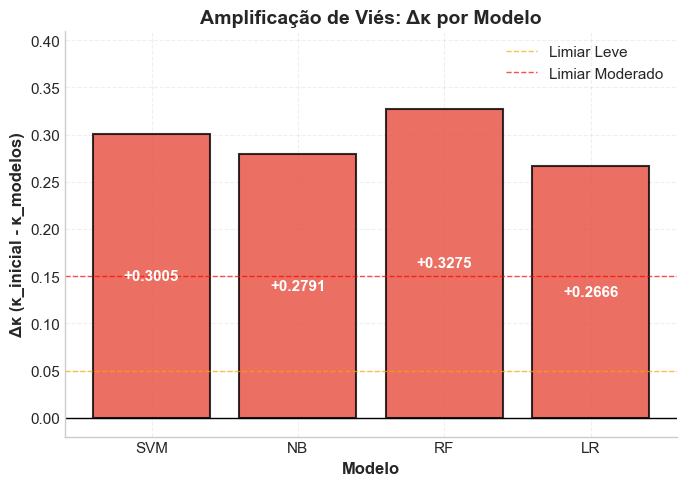

In [48]:
# Visualizar Δκ
fig, ax = plt.subplots(figsize=(7, 5))

cores = []
for severidade in df_divergencia['severidade']:
    if 'Ausente' in severidade:
        cores.append('#2ecc71')
    elif severidade == 'Leve':
        cores.append('#f39c12')
    elif severidade == 'Moderada':
        cores.append('#e67e22')
    else:
        cores.append('#e74c3c')

bars = ax.bar(df_divergencia['modelo'], df_divergencia['delta_kappa'],
              color=cores, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.axhline(y=0.05, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='Limiar Leve')
ax.axhline(y=0.15, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Limiar Moderado')
ax.set_xlabel('Modelo', fontsize=12, fontweight='bold')
ax.set_ylabel('Δκ (κ_inicial - κ_modelos)', fontsize=12, fontweight='bold')
ax.set_title('Amplificação de Viés: Δκ por Modelo', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

max_delta = df_divergencia['delta_kappa'].max()
min_delta = df_divergencia['delta_kappa'].min()
margin = max(abs(max_delta), abs(min_delta)) * 0.25
ax.set_ylim(min(min_delta - margin, -0.02), max(max_delta + margin, 0.20))

for bar in bars:
    height = bar.get_height()
    if abs(height) > 0.03:
        y_pos = height / 2
        color = 'white'
        va = 'center'
    else:
        y_pos = height + 0.015 if height >= 0 else height - 0.015
        color = 'black'
        va = 'bottom' if height >= 0 else 'top'
    
    ax.text(bar.get_x() + bar.get_width()/2., y_pos,
            f'{height:+.4f}', ha='center', va=va,
            fontsize=11, fontweight='bold', color=color)

plt.tight_layout()
plt.savefig(GRAFICOS_DIR / 'amplificacao_delta_kappa.png', dpi=300, bbox_inches='tight')
plt.show()

In [49]:
# Bootstrap para significância estatística
print("\nCalculando significância estatística (bootstrap)...\n")

n_bootstrap = 1000
resultados_bootstrap = []

for modelo in modelos.keys():
    pred_modelo = df_predicoes[df_predicoes['modelo'] == modelo]
    
    deltas_bootstrap = []
    
    for _ in range(n_bootstrap):
        idx = np.random.choice(len(pred_modelo), size=len(pred_modelo), replace=True)
        sample = pred_modelo.iloc[idx]
        
        kappa_sample = cohen_kappa_score(sample['pred_masculino'], sample['pred_feminino'])
        delta_sample = kappa_inicial - kappa_sample
        deltas_bootstrap.append(delta_sample)
    
    ci_lower = np.percentile(deltas_bootstrap, 2.5)
    ci_upper = np.percentile(deltas_bootstrap, 97.5)
    delta_mean = np.mean(deltas_bootstrap)
    
    significativo = ci_lower > 0 or ci_upper < 0
    direcao = "AMPLIFICA" if ci_lower > 0 else "REDUZ" if ci_upper < 0 else "NÃO SIGNIFICATIVO"
    
    resultados_bootstrap.append({
        'modelo': modelo,
        'delta_kappa': df_divergencia[df_divergencia['modelo'] == modelo]['delta_kappa'].values[0],
        'delta_bootstrap_mean': delta_mean,
        'ic_95_lower': ci_lower,
        'ic_95_upper': ci_upper,
        'significativo': significativo,
        'direcao': direcao
    })
    
    print(f"  {modelo}:")
    print(f"    Δκ observado: {resultados_bootstrap[-1]['delta_kappa']:+.4f}")
    print(f"    IC 95%: [{ci_lower:+.4f}, {ci_upper:+.4f}]")
    print(f"    → {direcao}")

df_bootstrap = pd.DataFrame(resultados_bootstrap)
df_bootstrap.to_csv(RESULTS_DIR / "significancia_delta_kappa.csv", index=False)

print("\n✓ Salvo: significancia_delta_kappa.csv")


Calculando significância estatística (bootstrap)...

  SVM:
    Δκ observado: +0.3005
    IC 95%: [+0.2620, +0.3411]
    → AMPLIFICA
  NB:
    Δκ observado: +0.2791
    IC 95%: [+0.2419, +0.3140]
    → AMPLIFICA
  RF:
    Δκ observado: +0.3275
    IC 95%: [+0.2870, +0.3679]
    → AMPLIFICA
  LR:
    Δκ observado: +0.2666
    IC 95%: [+0.2291, +0.3033]
    → AMPLIFICA

✓ Salvo: significancia_delta_kappa.csv


In [50]:
# Gerar relatório textual
output_file = RESULTS_DIR / "relatorio_amplificacao_vies.txt"

with open(output_file, 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write("RELATÓRIO DE AMPLIFICAÇÃO DE VIÉS - MIVA FASE 2\n")
    f.write("="*80 + "\n\n")
    
    f.write(f"Data: {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}\n")
    f.write(f"Seed: {SEED}\n")
    f.write(f"K-Fold: {N_FOLDS}\n")
    f.write(f"N Amostras: {len(df)}\n\n")
    
    f.write("-"*80 + "\n")
    f.write("BASELINE\n")
    f.write("-"*80 + "\n\n")
    
    for _, row in df_baseline.iterrows():
        if row['metrica'] in ['Cohen_Kappa', 'Weighted_Kappa', 'Concordancia', 'Cramers_V',
                               'Kappa_IC95_Lower', 'Kappa_IC95_Upper']:
            f.write(f"{row['metrica']:25}: {row['valor']:.4f}\n")
        elif row['metrica'] == 'Chi2':
            f.write(f"{row['metrica']:25}: {row['valor']:.2f}\n")
        elif row['metrica'] == 'p_value':
            f.write(f"{row['metrica']:25}: {row['valor']:.2e}\n")
        else:
            f.write(f"{row['metrica']:25}: {int(row['valor'])}\n")
    
    f.write("\n" + "-"*80 + "\n")
    f.write("AMPLIFICAÇÃO\n")
    f.write("-"*80 + "\n\n")
    
    f.write(f"κ_inicial: {kappa_inicial:.4f}\n\n")
    
    for _, row in df_divergencia.iterrows():
        f.write(f"{row['modelo']}:\n")
        f.write(f"  κ_modelos : {row['kappa_modelos']:.4f}\n")
        f.write(f"  Δκ        : {row['delta_kappa']:+.4f}\n")
        f.write(f"  Severidade: {row['severidade']}\n")
        f.write(f"  Amplifica?: {'SIM' if row['amplificacao_detectada'] else 'NÃO'}\n\n")
    
    f.write("="*80 + "\n")
    
    n_amplificados = df_divergencia['amplificacao_detectada'].sum()
    
    if n_amplificados == 0:
        f.write("✓ Nenhum modelo amplificou viés significativamente.\n")
    else:
        f.write(f"⚠ {n_amplificados}/{len(df_divergencia)} modelos amplificaram viés.\n")

print(f"\n✓ Relatório salvo: {output_file}")


✓ Relatório salvo: data\resultados_empiricos\relatorio_amplificacao_vies.txt


## Resumo Final

In [51]:
# Resumo consolidado
print("="*80)
print("RESUMO FINAL - MIVA FASE 2")
print("="*80)

print(f"\n📁 Resultados em: {RESULTS_DIR}/")

print("\n📊 CSVs gerados:")
for csv_file in sorted(RESULTS_DIR.glob('*.csv')):
    print(f"  • {csv_file.name}")

print(f"\n📈 Gráficos gerados ({len(list(GRAFICOS_DIR.glob('*.png')))} arquivos):")
for img_file in sorted(GRAFICOS_DIR.glob('*.png')):
    print(f"  • {img_file.name}")

print("\n" + "="*80)
print("✓ PIPELINE CONCLUÍDO")
print("="*80)

resumo = df_divergencia[['modelo', 'kappa_inicial', 'kappa_modelos', 
                          'delta_kappa', 'severidade']].copy()
for col in ['kappa_inicial', 'kappa_modelos', 'delta_kappa']:
    resumo[col] = resumo[col].apply(lambda x: f"{x:.4f}")

resumo

RESUMO FINAL - MIVA FASE 2

📁 Resultados em: data\resultados_empiricos/

📊 CSVs gerados:
  • divergencia_amplificacao.csv
  • metricas_consistencia_baseline.csv
  • metricas_modelos_pareados.csv
  • predicoes_completas.csv
  • significancia_delta_kappa.csv

📈 Gráficos gerados (5 arquivos):
  • amplificacao_delta_kappa.png
  • comparacao_kappas.png
  • distribuicao_classes.png
  • matriz_confusao_baseline.png
  • matrizes_confusao_modelos.png

✓ PIPELINE CONCLUÍDO


,modelo,kappa_inicial,kappa_modelos,delta_kappa,severidade
0,SVM,0.7652,0.4647,0.3005,Severa
1,NB,0.7652,0.4862,0.2791,Severa
2,RF,0.7652,0.4378,0.3275,Severa
3,LR,0.7652,0.4986,0.2666,Severa


In [52]:
# Interpretação focada em amplificação
print("="*80)
print("ANÁLISE FOCADA: AMPLIFICAÇÃO DE VIÉS")
print("="*80)

print(f"\n{'MODELO':<10} │ {'κ_inicial':^12} │ {'κ_modelos':^12} │ {'Δκ':^12} │ {'RESULTADO':^20}")
print("-"*80)

for _, row in df_divergencia.iterrows():
    if row['delta_kappa'] > 0.10:
        resultado = "⚠️ AMPLIFICA VIÉS"
    elif row['delta_kappa'] > 0.05:
        resultado = "⚡ Amplifica (leve)"
    elif row['delta_kappa'] < -0.05:
        resultado = "✓ Reduz viés"
    else:
        resultado = "≈ Preserva"
    
    print(f"{row['modelo']:<10} │ {row['kappa_inicial']:^12.4f} │ "
          f"{row['kappa_modelos']:^12.4f} │ {row['delta_kappa']:^+12.4f} │ {resultado:^20}")

print("-"*80)

delta_medio = df_divergencia['delta_kappa'].mean()

print(f"\n📊 Δκ médio: {delta_medio:+.4f}")
print(f"   κ_inicial: {kappa_inicial:.4f}")
print(f"   κ_modelos (média): {df_divergencia['kappa_modelos'].mean():.4f}")

print("\n" + "="*80)
print("INTERPRETAÇÃO:")
print("="*80)

if delta_medio > 0.05:
    print(f"\n⚠️ AMPLIFICAÇÃO DETECTADA (Δκ médio = {delta_medio:+.4f})")
    print(f"   Modelos concordam MENOS ({df_divergencia['kappa_modelos'].mean():.4f})")
    print(f"   que os anotadores ({kappa_inicial:.4f})")
    print("\n   → Modelos AMPLIFICAM as diferenças de perspectiva")
elif delta_medio < -0.05:
    print(f"\n✓ REDUÇÃO (Δκ médio = {delta_medio:+.4f})")
    print("   → Modelos REDUZEM as diferenças de perspectiva")
else:
    print(f"\n≈ PRESERVAÇÃO (Δκ médio = {delta_medio:+.4f})")
    print("   → Modelos PRESERVAM o nível de divergência original")

print("\n" + "="*80)

ANÁLISE FOCADA: AMPLIFICAÇÃO DE VIÉS

MODELO     │  κ_inicial   │  κ_modelos   │      Δκ      │      RESULTADO      
--------------------------------------------------------------------------------
SVM        │    0.7652    │    0.4647    │   +0.3005    │  ⚠️ AMPLIFICA VIÉS  
NB         │    0.7652    │    0.4862    │   +0.2791    │  ⚠️ AMPLIFICA VIÉS  
RF         │    0.7652    │    0.4378    │   +0.3275    │  ⚠️ AMPLIFICA VIÉS  
LR         │    0.7652    │    0.4986    │   +0.2666    │  ⚠️ AMPLIFICA VIÉS  
--------------------------------------------------------------------------------

📊 Δκ médio: +0.2934
   κ_inicial: 0.7652
   κ_modelos (média): 0.4718

INTERPRETAÇÃO:

⚠️ AMPLIFICAÇÃO DETECTADA (Δκ médio = +0.2934)
   Modelos concordam MENOS (0.4718)
   que os anotadores (0.7652)

   → Modelos AMPLIFICAM as diferenças de perspectiva

